# <u>**Time-Series Demand Forecast Model**</u>

In this notebook, advanced time-series forecasting techniques are demonstrated on 5 years worth of synthetic supply chain data. This dataset contains information on order count, piece count, and total revenue information for daily deliveries across various locations and customers.

### <u>**Contents**</u>

- [1 - Import Packages](#1---import-packages)
- [2 - Import Dataset](#2---import-dataset)
- [3 - Exploratory Data Analysis (EDA)](#3---exploratory-data-analysis-eda)
- [4 - Feature Engineering](#4---feature-engineering)
- [5 - Cross Validation and Hyperparameter Tuning](#5---cross-validation-and-hyperparameter-tuning)
    - [5.1 - Preprocessing](#51---preprocessing)
- [6 - Training and Testing the Model](#6---training-and-testing-the-model)
- [7 - Analyze Model Performance](#7---analyze-model-performance)
- [8 - Predict the Future](#8---predict-the-future)
- [9 - Conclusion](#9---conclusion)

<a id="1"></a>
### 1 - Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import calendar
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

<a id="2"></a>
### 2 - Import Dataset

In [2]:
df = pd.read_csv('supply_chain_deliveries.csv')

In [3]:
df.shape

(126255, 7)

In [4]:
df.head()

,WorkDate,Customer,Location,BusinessType,OrderCount,NumberOfPieces,TotalRevenue
0,2020-01-02,Amazon,Chicago,Final Mile,38,190,2084.09
1,2020-01-02,Home Depot,Sacramento,Final Mile,34,136,6153.01
2,2020-01-02,Home Depot,Chicago,Final Mile,43,215,15691.72
3,2020-01-02,Home Depot,Detroit,Final Mile,41,164,6490.39
4,2020-01-02,Home Depot,Atlanta,Final Mile,44,220,10069.65


From the cell below, we see that we have both numerical and categorical variables to consider when developing our model

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126255 entries, 0 to 126254
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   WorkDate        126255 non-null  object 
 1   Customer        126255 non-null  object 
 2   Location        126255 non-null  object 
 3   BusinessType    126255 non-null  object 
 4   OrderCount      126255 non-null  int64  
 5   NumberOfPieces  126255 non-null  int64  
 6   TotalRevenue    126255 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 6.7+ MB


For the purposes of time-series forecasting, it's always best practice to set your date or datetime column as the index

In [6]:
df.WorkDate = pd.to_datetime(df.WorkDate)
df = df.set_index('WorkDate')

In [7]:
df.head()

,Customer,Location,BusinessType,OrderCount,NumberOfPieces,TotalRevenue
WorkDate,,,,,,
2020-01-02,Amazon,Chicago,Final Mile,38,190,2084.09
2020-01-02,Home Depot,Sacramento,Final Mile,34,136,6153.01
2020-01-02,Home Depot,Chicago,Final Mile,43,215,15691.72
2020-01-02,Home Depot,Detroit,Final Mile,41,164,6490.39
2020-01-02,Home Depot,Atlanta,Final Mile,44,220,10069.65


From the cell below, we can see that there are no null values in the dataset. This will almost definitely not be the case for real-world datasets, but was intentionally done for the sake of this exercise. Later, during feature engineering, we will run into null values and discuss how best to handle them.

In [8]:
df.isna().sum().sort_values(ascending=False)

Customer          0
Location          0
BusinessType      0
OrderCount        0
NumberOfPieces    0
TotalRevenue      0
dtype: int64

<a id="3"></a>
### 3 - Exploratory Data Analysis (EDA)

In this section, we will perform exploratory data analysis on our dataset in order to get a quick glimpse at various patterns and relationships within the dataset. This part is crucial in the machine learning model development process because it can provide insight into the data itself and can give us some clues as to what we should expect from our results.

From the graphs outputted by the cell below, we can see the seasonality of the dataset and a slight upward trend year-over-year for the ``TotalRevenue``, ``OrderCount``, and ``NumberOfPieces`` columns

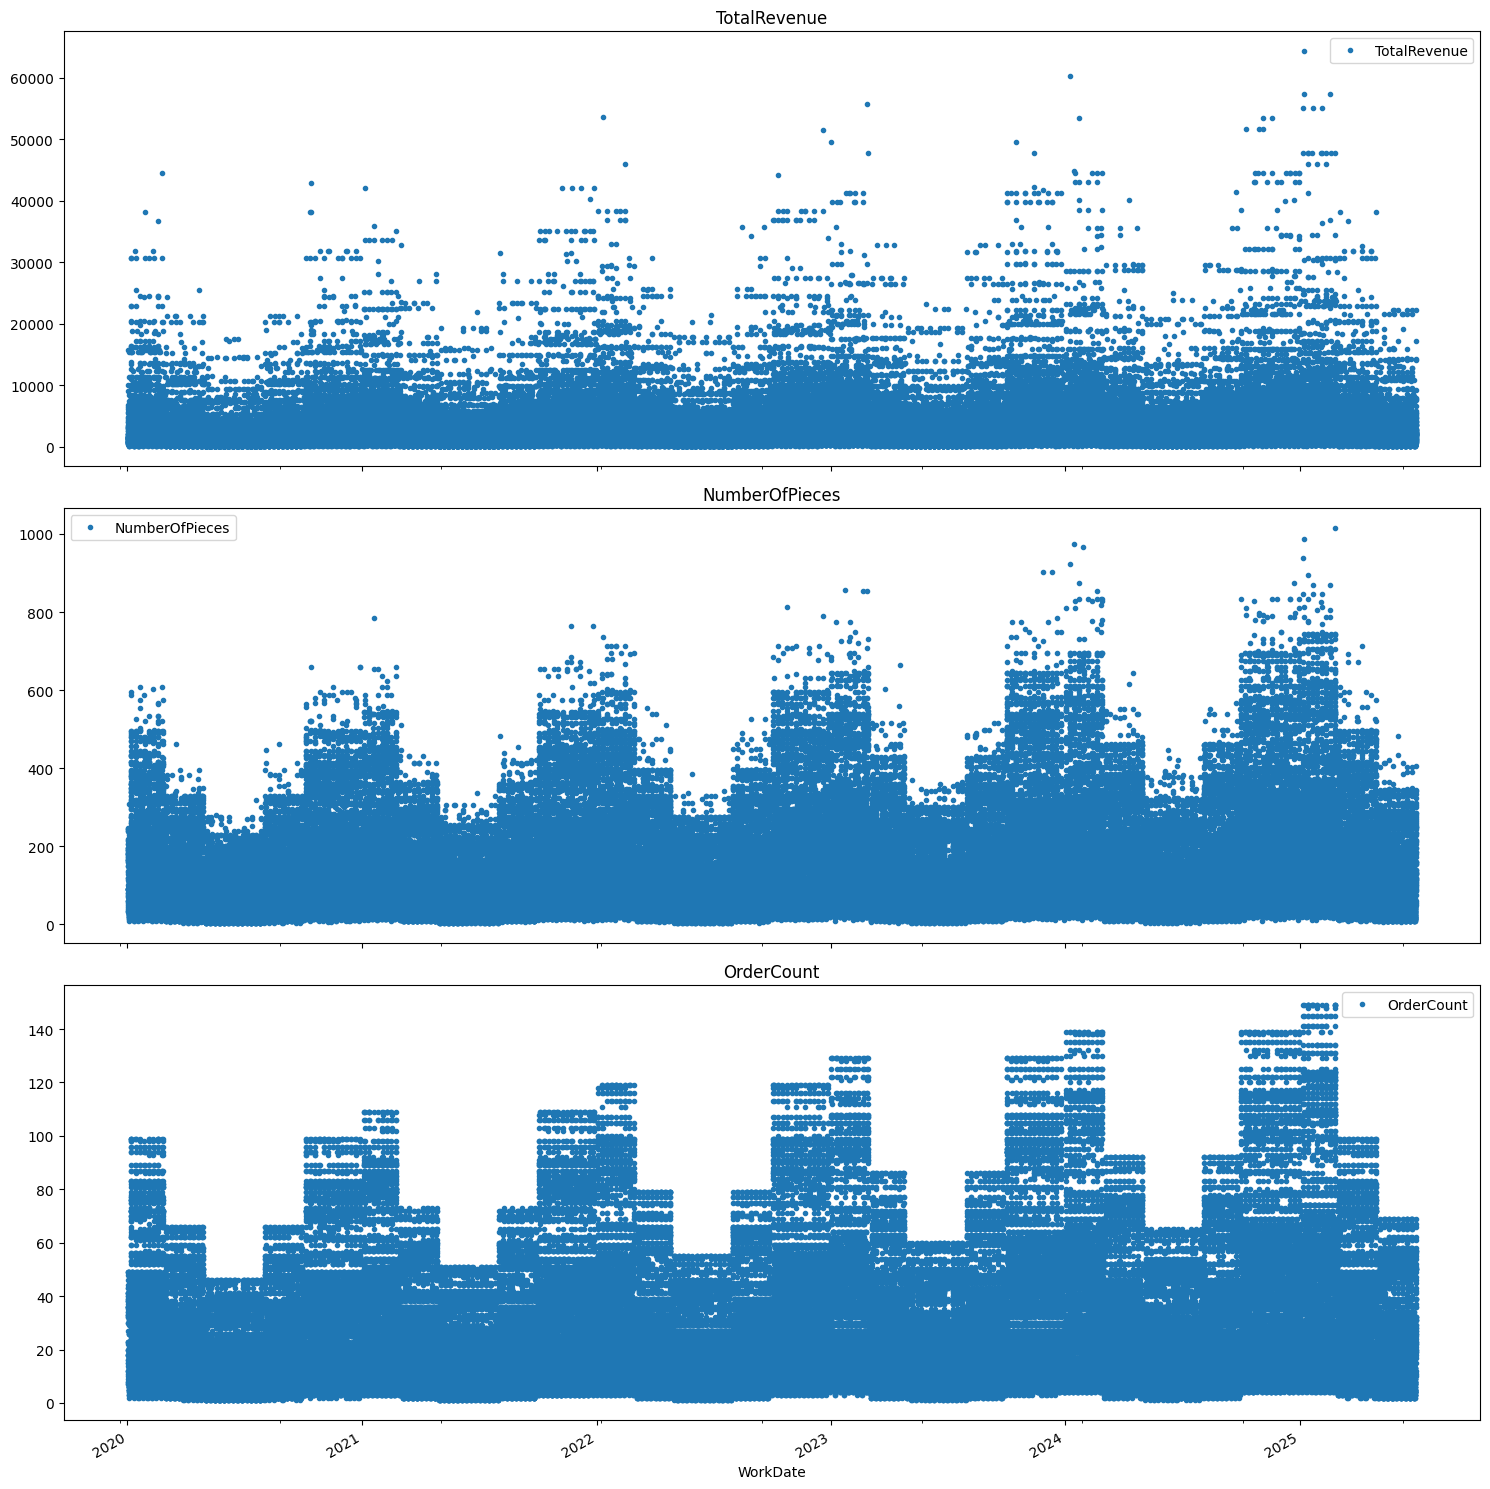

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(15,15), sharex=True)
for idx, col in enumerate(['TotalRevenue', 'NumberOfPieces', 'OrderCount']):
    df[[col]].plot(style='.', ax=ax[idx])
    ax[idx].set_title(col)
plt.tight_layout()
plt.show()

When we take a look at the distribution of the ``TotalRevenue``, ``OrderCount``, and ``NumberOfPieces`` columns, we see that all three are right-skewed. These three columns are going to be target features for us in this notebook ( I'll go into more detail as to why that is later ), so at some point we are going to want to normalize them.<br></br>
We want to do this because we are going to use ``XGBRegressor`` as our model. More information on what ``XGBoost`` is can be found here: https://xgboost.readthedocs.io/en/latest/python/python_api.html.<br></br>
This model already tends to use conservative hyperparamters so if we train our model on a skewed target variable, the minimized loss is going to be higher than it would otherwise be if we trained the model on normalized data.<br></br>
The output from the cell below shows this skewedness of the data and two options for normalization. Keep in mind there are many ways to normalize data and I encourage you to explore other options to see what works best, but for this exercise we are going to use ``np.log()`` to normalize the target variables.

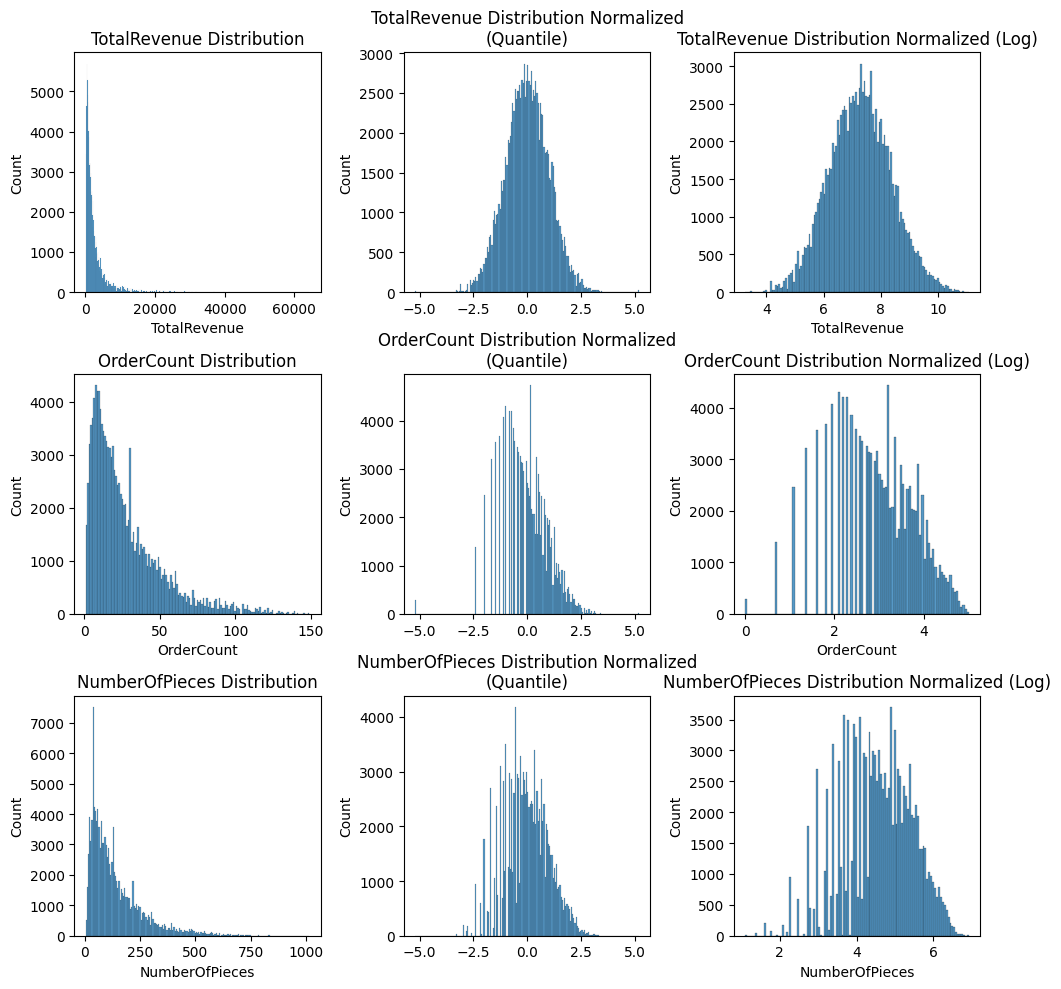

In [10]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
for idx, col in enumerate(['TotalRevenue', 'OrderCount', 'NumberOfPieces']):
    sns.histplot(df[col], ax=ax[idx][0])
    ax[idx][0].set_title(f'{col} Distribution')

    transformer = QuantileTransformer(output_distribution='normal', random_state=42)
    sns.histplot(transformer.fit_transform(df[col].values.reshape(-1,1)).flatten(), ax=ax[idx][1])
    ax[idx][1].set_title(f'{col} Distribution Normalized\n(Quantile)')

    sns.histplot(np.log(df[col]), ax=ax[idx][2])
    ax[idx][2].set_title(f'{col} Distribution Normalized (Log)')

plt.tight_layout()
plt.show()

In [11]:
num_cols = df.select_dtypes(include=np.number).columns

The output below shows the correlation between the three target variables. As you can see, ``OrderCount`` and ``NumberOfPieces`` are tightly correlated; however, while both share a positive correlation with ``TotalRevenue``, neither are as high as you might expect intuitively.<br></br>
However, when it comes to **logistics** and **supply chain management**, there are several factors that go into receiving revenue on orders. The two highlighted in this dataset are ``Location`` and ``Customer``.<br></br>
Each ``Customer`` is negotiated differently; depending on the type of freight being delivered (i.e. cartons, totes, pallets), they have different prices per piece and varying pieces per order.<br></br>
Likewise, each ``Location`` has different factors that contribute to the revenue. Some customers may have more stores in that location, meaning more deliveries are being made, or they may have stores that are closer or farther away from the hub location, affecting the amount of time on the road and fuel spent by drivers. Additionally, geographical and economic factors contribute to gas prices which varies by location and will have to be taken into account when negotiating pricing.<br></br>
All of these factors contribute to how the revenue is calculated for each ``Location`` and ``Customer`` and highlight the importance of having domain knowledge when the results from the data don't follow intuition.

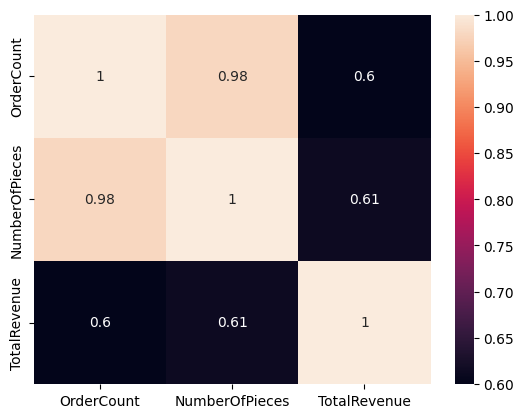

In [12]:
sns.heatmap(df[num_cols].corr(), annot=True)
plt.show()

In [13]:
object_cols = df.select_dtypes(include='object').columns

In the output from the cell below, we can identify some outlier categories in different categorical features. We can create features based on these outlier categories to help the model's performance. We'll use ``OneHotEncoder`` to create similar features, but these "duplicate" features will only support the model's performance.

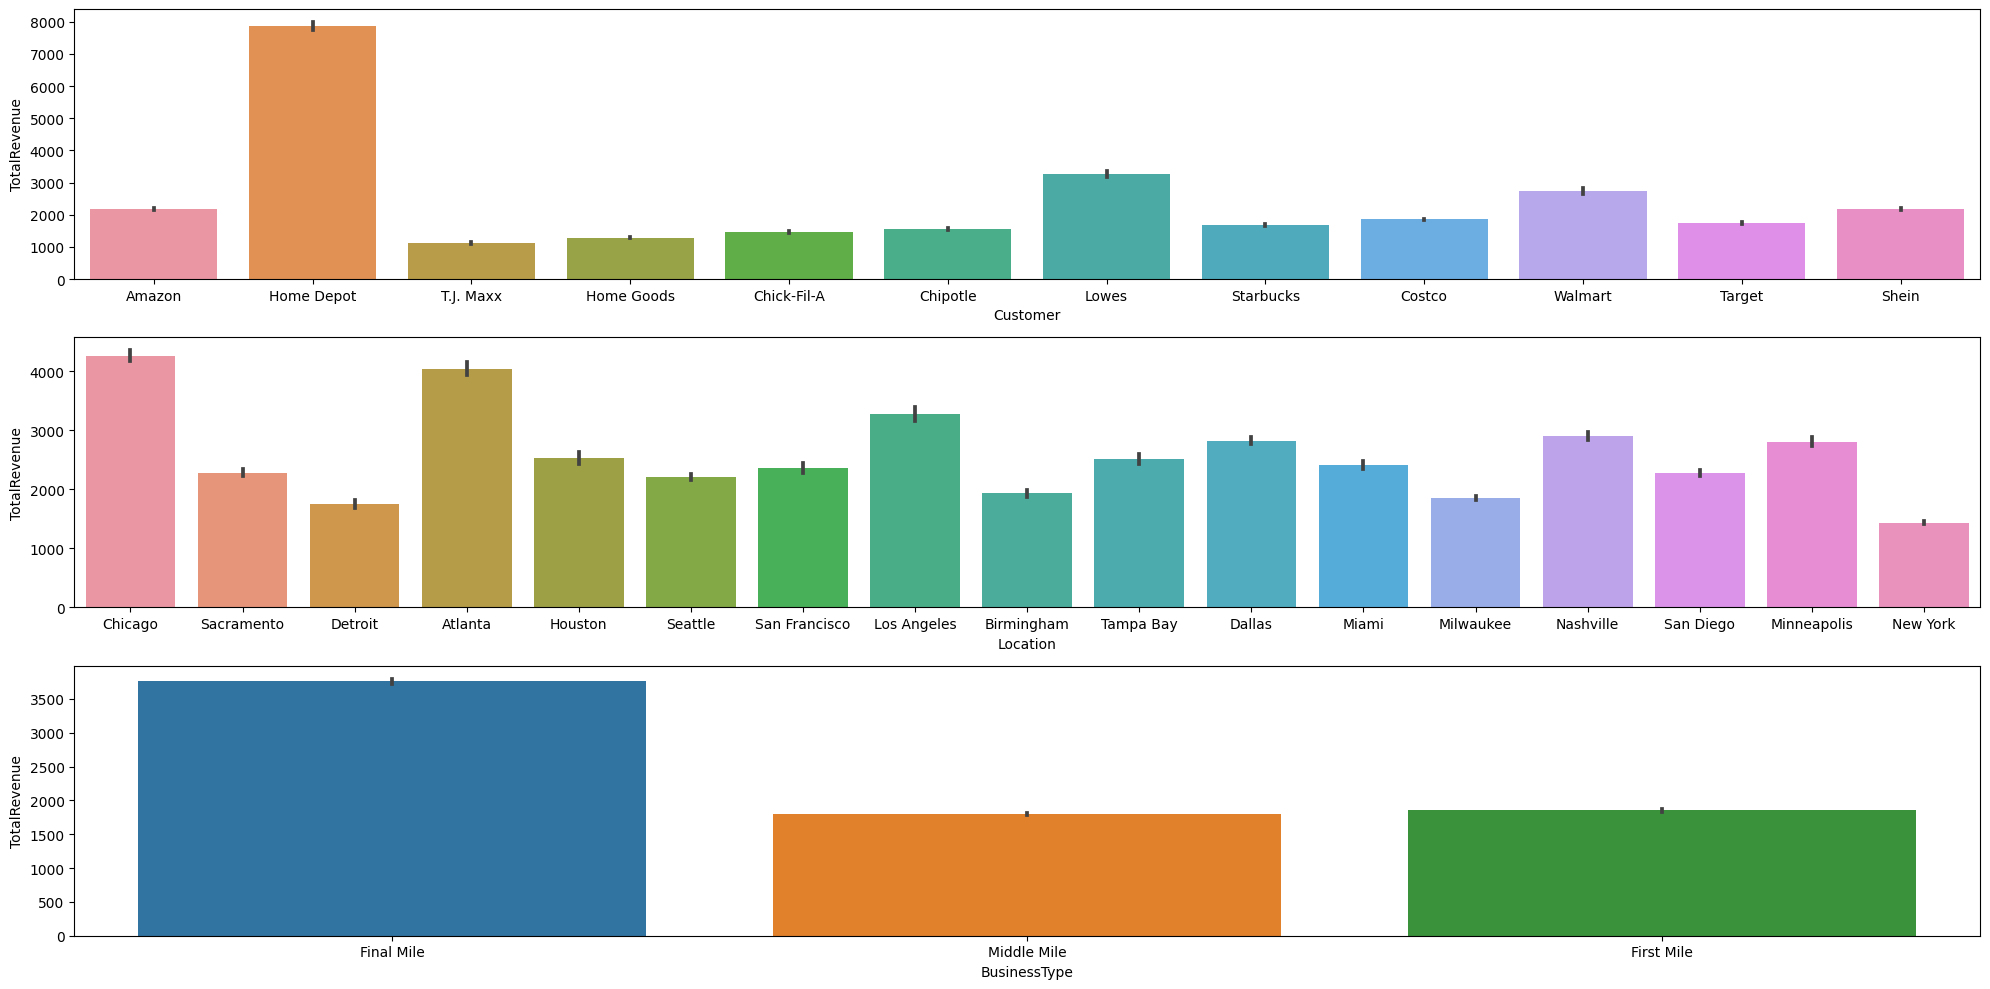

In [14]:
fig, ax = plt.subplots(len(object_cols), 1, figsize=(20,10))
for idx, col in enumerate(object_cols):
    sns.barplot(data=df, x=col, y='TotalRevenue', ax=ax[idx])
plt.tight_layout()
plt.show()

<a id="4"></a>
### 4 - Feature Engineering

On top of the outlier categories, we can create additional features based on the ``WorkDate`` that could provide additional insight into the seasonality and trend of the data.

In [15]:
def create_features(df):
    df['dayofweek'] = df.index.dayofweek
    df['weekofmonth'] = df.reset_index().WorkDate.apply(lambda x: (x.day - 1) // 7 + 1).values
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['month_start'] = df.index.is_month_start
    df['month_end'] = df.index.is_month_end
    df['year_start'] = df.index.is_year_start
    df['year_end'] = df.index.is_year_end
    df['isWeekend'] = df.dayofweek.isin([5,6])

    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df['isHoliday'] = df.index.isin(holidays)
    df['isDayBeforeHoliday'] = (df.index+timedelta(days=1)).isin(holidays)
    df['isDayAfterHoliday'] = (df.index-timedelta(days=1)).isin(holidays)
    
    try:
        df['isHomeDepot'] = df['Customer'] == 'Home Depot'
        df['isFinalMile'] = df['BusinessType'] == 'Final Mile'
    except KeyError:
        pass

    return df

In [16]:
df = create_features(df)

In [17]:
df.head()

,Customer,Location,BusinessType,OrderCount,NumberOfPieces,TotalRevenue,dayofweek,weekofmonth,weekofyear,quarter,month,year,month_start,month_end,year_start,year_end,isWeekend,isHoliday,isDayBeforeHoliday,isDayAfterHoliday,isHomeDepot,isFinalMile
WorkDate,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,Amazon,Chicago,Final Mile,38,190,2084.09,3,1,1,1,1,2020,False,False,False,False,False,False,False,False,False,True
2020-01-02,Home Depot,Sacramento,Final Mile,34,136,6153.01,3,1,1,1,1,2020,False,False,False,False,False,False,False,False,True,True
2020-01-02,Home Depot,Chicago,Final Mile,43,215,15691.72,3,1,1,1,1,2020,False,False,False,False,False,False,False,False,True,True
2020-01-02,Home Depot,Detroit,Final Mile,41,164,6490.39,3,1,1,1,1,2020,False,False,False,False,False,False,False,False,True,True
2020-01-02,Home Depot,Atlanta,Final Mile,44,220,10069.65,3,1,1,1,1,2020,False,False,False,False,False,False,False,False,True,True


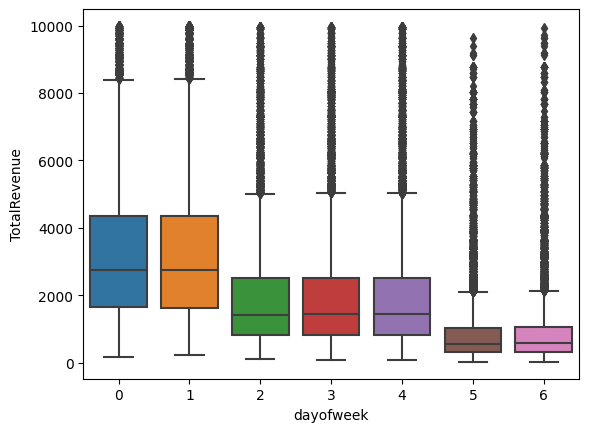

In [18]:
sns.boxplot(data=df[df.TotalRevenue < 10_000], x='dayofweek', y='TotalRevenue')
plt.show()

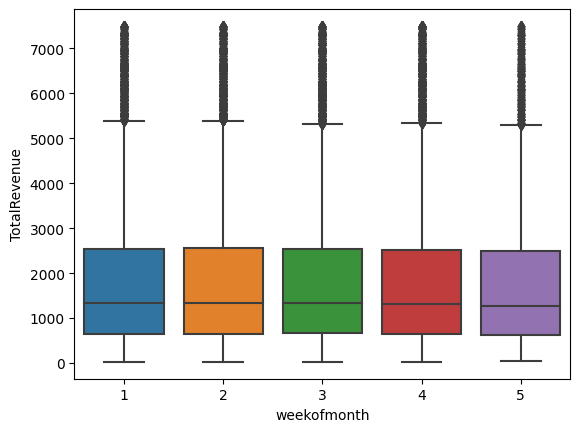

In [19]:
sns.boxplot(data=df[df.TotalRevenue < 7500], x='weekofmonth', y='TotalRevenue')
plt.show()

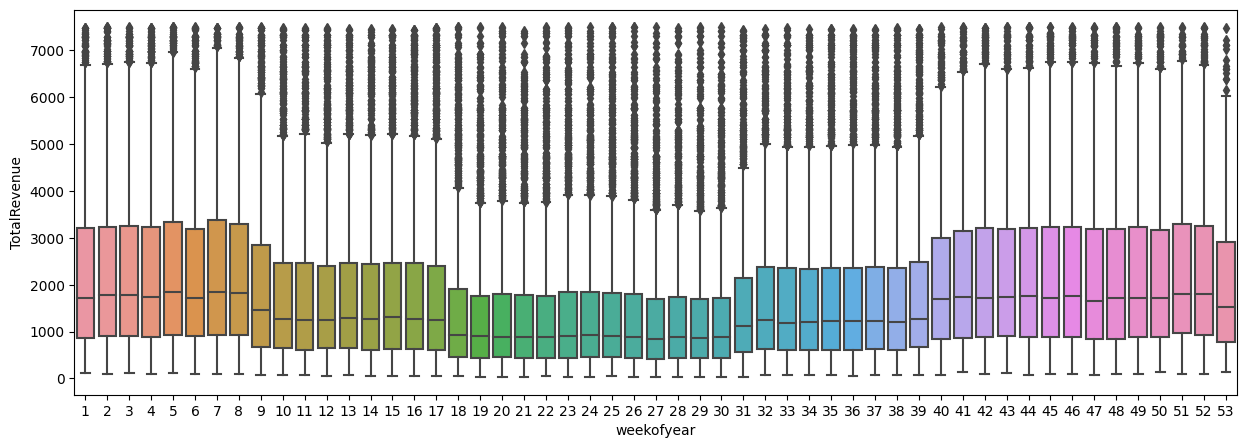

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df[df.TotalRevenue < 7500], x='weekofyear', y='TotalRevenue')
plt.show()

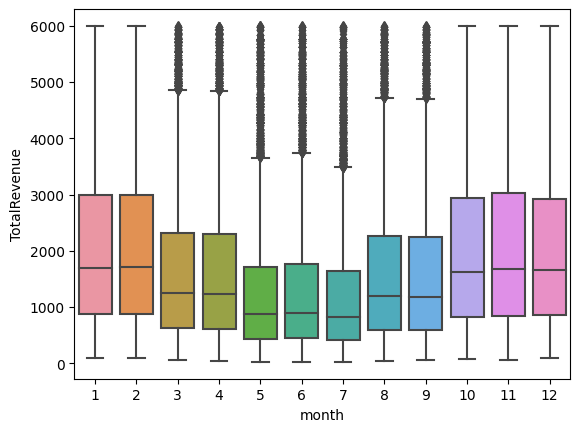

In [21]:
sns.boxplot(data=df[df.TotalRevenue < 6000], x='month', y='TotalRevenue')
plt.show()

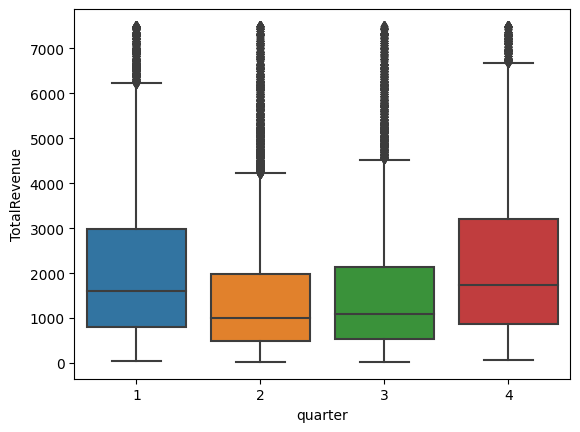

In [22]:
sns.boxplot(data=df[df.TotalRevenue < 7500], x='quarter', y='TotalRevenue')
plt.show()

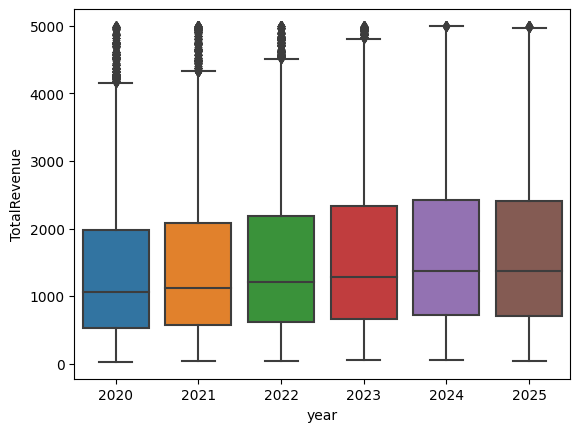

In [23]:
sns.boxplot(data=df[df.TotalRevenue < 5000], x='year', y='TotalRevenue')
plt.show()

From the graphs above, we can see some clear trends and patterns:
- There is a clear spike in revenue at the beginning of the week and it slowly decreases as the week goes on, with the least amount of revenue being generated over the weekend
- There is also a clear peak season from October to February, with a lull in revenue in the spring and summer months
- There has been a clear increase in overall revenue generated over the last 5 years

In the cell below, we will generate some lag and rolling features.<br></br>
**Lag** features return the value of a specified variable at a previous moment in time. For example, we can look at the amount of revenue generated by a given ``Customer`` in a given ``Location`` one week ago to make an assumption for what the revenue may be on the current day.<br></br>
**Rolling** features return an aggregation of a specified variable over a given period of time. For example, we can look at that same ``Customer`` and ``Location`` as the **lag** feature, but instead of returning a **single** value from the past week, we can take the **average** revenue from the past week<br></br>

In [24]:
def addLags(df, days):
    for col in ['TotalRevenue', 'NumberOfPieces', 'OrderCount']:
        # Group the dataframe by location and customer and then resample the data so that any days that were missing between deliveries are accounted for
        grouped = df.groupby(['Location', 'Customer'])[col].resample('D').mean().reset_index().set_index('WorkDate')

        def add_features(group):
            group = group.sort_index()
            for day in days:
                group[f'{col}_{day}_day_lag'] = group[col].shift(day)
                
                # Setting the closed argument to 'left' will prevent data leakage by not including the current day in the rolling calculation
                group[f'{col}_{day}_day_rolling_avg'] = group[col].rolling(f'{day}D', closed='left').mean()
                group[f'{col}_{day}_day_rolling_std'] = group[col].rolling(f'{day}D', closed='left').std()
                group[f'{col}_{day}_day_rolling_median'] = group[col].rolling(f'{day}D', closed='left').median()
            return group.reset_index()
        
        grouped_features = grouped.groupby(['Location', 'Customer']).apply(add_features).reset_index(drop=True)

        duplicate_columns = [
            col for col in grouped_features.columns if col in df.columns and '_day_' in col
        ]

        # Dropping the lag and rolling columns here will prevent duplicate columns being added to the dataset if we call this function on a dataframe
        # more than once, which, spoiler alert, we will be doing later in this notebook
        if duplicate_columns:
            df.drop(duplicate_columns, axis=1, inplace=True)

        df = pd.merge(
            df,
            grouped_features.drop(col, axis=1),
            on=['WorkDate', 'Location', 'Customer'],
            how='left'
        ).set_index('WorkDate').sort_index()

    return df

In [25]:
df = addLags(df, [7, 14, 21, 30, 60, 90])

In [26]:
df.tail()

,Customer,Location,BusinessType,OrderCount,NumberOfPieces,TotalRevenue,dayofweek,weekofmonth,weekofyear,quarter,month,year,month_start,month_end,year_start,year_end,isWeekend,isHoliday,isDayBeforeHoliday,isDayAfterHoliday,isHomeDepot,isFinalMile,TotalRevenue_7_day_lag,TotalRevenue_7_day_rolling_avg,TotalRevenue_7_day_rolling_std,TotalRevenue_7_day_rolling_median,TotalRevenue_14_day_lag,TotalRevenue_14_day_rolling_avg,TotalRevenue_14_day_rolling_std,TotalRevenue_14_day_rolling_median,TotalRevenue_21_day_lag,TotalRevenue_21_day_rolling_avg,TotalRevenue_21_day_rolling_std,TotalRevenue_21_day_rolling_median,TotalRevenue_30_day_lag,TotalRevenue_30_day_rolling_avg,TotalRevenue_30_day_rolling_std,TotalRevenue_30_day_rolling_median,TotalRevenue_60_day_lag,TotalRevenue_60_day_rolling_avg,TotalRevenue_60_day_rolling_std,TotalRevenue_60_day_rolling_median,TotalRevenue_90_day_lag,TotalRevenue_90_day_rolling_avg,TotalRevenue_90_day_rolling_std,TotalRevenue_90_day_rolling_median,NumberOfPieces_7_day_lag,NumberOfPieces_7_day_rolling_avg,NumberOfPieces_7_day_rolling_std,NumberOfPieces_7_day_rolling_median,NumberOfPieces_14_day_lag,NumberOfPieces_14_day_rolling_avg,NumberOfPieces_14_day_rolling_std,NumberOfPieces_14_day_rolling_median,NumberOfPieces_21_day_lag,NumberOfPieces_21_day_rolling_avg,NumberOfPieces_21_day_rolling_std,NumberOfPieces_21_day_rolling_median,NumberOfPieces_30_day_lag,NumberOfPieces_30_day_rolling_avg,NumberOfPieces_30_day_rolling_std,NumberOfPieces_30_day_rolling_median,NumberOfPieces_60_day_lag,NumberOfPieces_60_day_rolling_avg,NumberOfPieces_60_day_rolling_std,NumberOfPieces_60_day_rolling_median,NumberOfPieces_90_day_lag,NumberOfPieces_90_day_rolling_avg,NumberOfPieces_90_day_rolling_std,NumberOfPieces_90_day_rolling_median,OrderCount_7_day_lag,OrderCount_7_day_rolling_avg,OrderCount_7_day_rolling_std,OrderCount_7_day_rolling_median,OrderCount_14_day_lag,OrderCount_14_day_rolling_avg,OrderCount_14_day_rolling_std,OrderCount_14_day_rolling_median,OrderCount_21_day_lag,OrderCount_21_day_rolling_avg,OrderCount_21_day_rolling_std,OrderCount_21_day_rolling_median,OrderCount_30_day_lag,OrderCount_30_day_rolling_avg,OrderCount_30_day_rolling_std,OrderCount_30_day_rolling_median,OrderCount_60_day_lag,OrderCount_60_day_rolling_avg,OrderCount_60_day_rolling_std,OrderCount_60_day_rolling_median,OrderCount_90_day_lag,OrderCount_90_day_rolling_avg,OrderCount_90_day_rolling_std,OrderCount_90_day_rolling_median
WorkDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-30,Costco,Los Angeles,First Mile,23,115,2659.43,0,5,27,2,6,2025,False,True,False,False,False,False,False,False,False,False,2659.43,1819.203333,738.690013,1526.28,2659.43,1593.087778,871.852685,1271.900,2659.43,1539.770833,894.095510,1271.900,555.01,1377.791053,858.150172,1271.900,1271.90,1386.400244,851.711057,1271.90,NaN,1686.690794,1074.581007,1271.90,115.0,78.666667,31.942657,66.0,115.0,68.888889,37.700943,55.0,115.0,66.583333,38.662781,55.0,24.0,59.578947,37.108423,55.0,55.0,59.951220,36.829982,55.0,NaN,72.936508,46.467426,55.0,23.0,15.0,6.928203,11.0,23.0,13.444444,7.715425,11.0,23.0,13.250000,7.759159,11.0,4.0,11.947368,7.442175,11.0,11.0,11.878049,7.064684,11.0,NaN,14.412698,9.031549,11.0
2025-06-30,Costco,Chicago,First Mile,11,55,2086.51,0,5,27,2,6,2025,False,True,False,False,False,False,False,False,False,False,NaN,789.076000,527.303142,758.73,2086.51,907.025455,551.178279,758.730,1669.20,919.399412,517.302984,948.410,NaN,1026.089524,640.608612,948.410,1138.09,1052.236579,682.384247,948.41,3224.60,1251.237544,841.853899,948.41,NaN,20.800000,13.899640,20.0,55.0,23.909091,14.528968,20.0,44.0,24.235294,13.636025,25.0,NaN,27.047619,16.886315,25.0,30.0,27.736842,17.987509,25.0,85.0,32.982456,22.191127,25.0,NaN,5.0,3.674235,5.0,11.0,5.000000,3.286335,5.0,11.0,5.000000,3.181981,5.0,NaN,5.428571,3.457910,5.0,5.0,5.473684,3.383081,5.0,17.0,6.578947,4.443886,5.0
2025-06-30,Costco,Birmingham,First Mile,10,50,780.81,0,5,2

In the function below, we will creating expanded variables that will help provide clearer historical context to a given variable.<br></br>
The **expanded** values will act as "***boundaries***" in the sense that they will define the highest and lowest statistics seen so far in the dataset for a given variable.<br></br>
The **ewm** or exponentially weighted movement variables smooth the data points for a given variable while providing more weight to recent values, ultimately returning a specified statistic such as **mean** or **standard deviation** based on that smoothed data.

In [27]:
def expand_group(group):
    group = group.sort_values(by='WorkDate')
    for col in ['TotalRevenue', 'NumberOfPieces', 'OrderCount']:
        group[f'{col}_expanded_min'] = group[col].expanding().min().shift(1)
        group[f'{col}_expanded_max'] = group[col].expanding().max().shift(1)
        group[f'{col}_expanded_mean'] = group[col].expanding().mean().shift(1)
        group[f'{col}_expanded_std'] = group[col].expanding().std().shift(1)
        group[f'{col}_expanded_median'] = group[col].expanding().median().shift(1)

        # The alpha argument is a smoothing factor that determines how much weight is given to recent values vs older values.
        # A higher alpha will react more to recent changes
        group[f'{col}_ewm_mean'] = group[col].ewm(alpha=0.23).mean().shift(1)
        group[f'{col}_ewm_std'] = group[col].ewm(alpha=0.23).std().shift(1)
    return group

In [28]:
df = df.groupby(['Location', 'Customer'], group_keys=False).apply(expand_group)

<a id="5"></a>
### 5 - Cross Validation and Hyperparameter Tuning

**Cross-validation** is a process the helps prevent overfitting by separating the data in to a train and test set, training a model on that training set, and then testing that model on the rest of the unseen data. The key to cross-validation is to repeat this process multiple times on **random** training and test sets and compare the results of each iteration or **fold**.<br></br>

<center>
<img src="https://dataaspirant.com/wp-content/uploads/2020/12/4-Cross-Validation-Procedure-1536x504.png" alt="Cross-Validation"><br></br>
</center>

In traditional machine learning problems, splitting the data in this way isn't an issue, but forecasting models like the one we are building are **time-dependent**, meaning that training a model on a random chunk of our data and then testing in on the rest of the data will introduce data leakage and it's unrealistic to train a model on future data then test it on past data.<br></br>

Instead, we will use ``TimeSeriesSplit`` to split the data into train and test sets, but the training data will **always** be in the past relative to the test data.


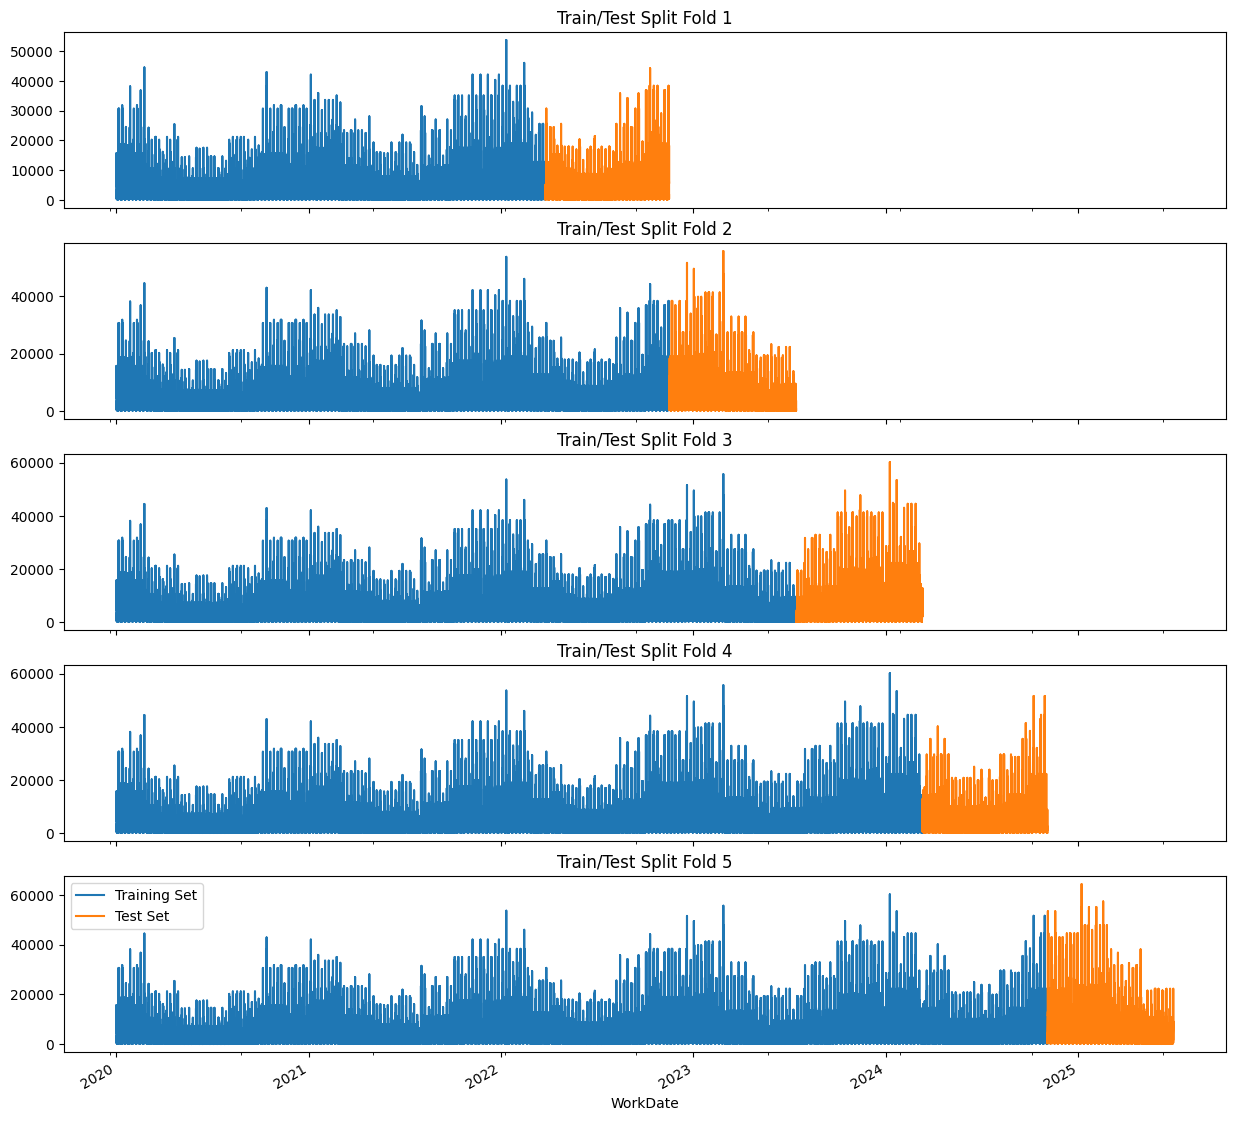

In [29]:
# Splits and test sizes were arbitrarily chosen, feel free to play around with these values to achieve your desired result

splits = 5
tss = TimeSeriesSplit(n_splits=splits, test_size=15_000)
df = df.sort_index()

fig, ax = plt.subplots(splits, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['TotalRevenue'].plot(ax=ax[fold],
                               label='Training Set',
                               title=f'Train/Test Split Fold {fold+1}')
    test['TotalRevenue'].plot(ax=ax[fold], label='Test Set')
    fold+=1

plt.legend()
plt.show()

Now that we have the train/test splits, we can perform cross validation for each target variable. For the purposes of this exercise, we'll only perform cross-validation on a model that targets the ``TotalRevenue`` variable.

In [30]:
target = 'TotalRevenue'

We're going to drop the target variables from the training set because on any given day, if we know the ``TotalRevenue`` then we know the ``OrderCount`` and ``NumberOfPieces`` as well. In other words, if we use any of the target variables in the training set, we will leak some information about the specific target variable we are predicting. This is also why we took the necessary steps to minimize data leakage when engineering features in ``addLags()`` and ``expand_group()``.

In [31]:
drop_cols = ['TotalRevenue', 'OrderCount', 'NumberOfPieces']

In [32]:
x_train = df.copy().drop(drop_cols, axis=1)
y_train = np.log(df[target]) # Applying log to target variable

In [33]:
x_train.shape

(126255, 112)

In [34]:
x_train.head()

,Customer,Location,BusinessType,dayofweek,weekofmonth,weekofyear,quarter,month,year,month_start,month_end,year_start,year_end,isWeekend,isHoliday,isDayBeforeHoliday,isDayAfterHoliday,isHomeDepot,isFinalMile,TotalRevenue_7_day_lag,TotalRevenue_7_day_rolling_avg,TotalRevenue_7_day_rolling_std,TotalRevenue_7_day_rolling_median,TotalRevenue_14_day_lag,TotalRevenue_14_day_rolling_avg,TotalRevenue_14_day_rolling_std,TotalRevenue_14_day_rolling_median,TotalRevenue_21_day_lag,TotalRevenue_21_day_rolling_avg,TotalRevenue_21_day_rolling_std,TotalRevenue_21_day_rolling_median,TotalRevenue_30_day_lag,TotalRevenue_30_day_rolling_avg,TotalRevenue_30_day_rolling_std,TotalRevenue_30_day_rolling_median,TotalRevenue_60_day_lag,TotalRevenue_60_day_rolling_avg,TotalRevenue_60_day_rolling_std,TotalRevenue_60_day_rolling_median,TotalRevenue_90_day_lag,TotalRevenue_90_day_rolling_avg,TotalRevenue_90_day_rolling_std,TotalRevenue_90_day_rolling_median,NumberOfPieces_7_day_lag,NumberOfPieces_7_day_rolling_avg,NumberOfPieces_7_day_rolling_std,NumberOfPieces_7_day_rolling_median,NumberOfPieces_14_day_lag,NumberOfPieces_14_day_rolling_avg,NumberOfPieces_14_day_rolling_std,NumberOfPieces_14_day_rolling_median,NumberOfPieces_21_day_lag,NumberOfPieces_21_day_rolling_avg,NumberOfPieces_21_day_rolling_std,NumberOfPieces_21_day_rolling_median,NumberOfPieces_30_day_lag,NumberOfPieces_30_day_rolling_avg,NumberOfPieces_30_day_rolling_std,NumberOfPieces_30_day_rolling_median,NumberOfPieces_60_day_lag,NumberOfPieces_60_day_rolling_avg,NumberOfPieces_60_day_rolling_std,NumberOfPieces_60_day_rolling_median,NumberOfPieces_90_day_lag,NumberOfPieces_90_day_rolling_avg,NumberOfPieces_90_day_rolling_std,NumberOfPieces_90_day_rolling_median,OrderCount_7_day_lag,OrderCount_7_day_rolling_avg,OrderCount_7_day_rolling_std,OrderCount_7_day_rolling_median,OrderCount_14_day_lag,OrderCount_14_day_rolling_avg,OrderCount_14_day_rolling_std,OrderCount_14_day_rolling_median,OrderCount_21_day_lag,OrderCount_21_day_rolling_avg,OrderCount_21_day_rolling_std,OrderCount_21_day_rolling_median,OrderCount_30_day_lag,OrderCount_30_day_rolling_avg,OrderCount_30_day_rolling_std,OrderCount_30_day_rolling_median,OrderCount_60_day_lag,OrderCount_60_day_rolling_avg,OrderCount_60_day_rolling_std,OrderCount_60_day_rolling_median,OrderCount_90_day_lag,OrderCount_90_day_rolling_avg,OrderCount_90_day_rolling_std,OrderCount_90_day_rolling_median,TotalRevenue_expanded_min,TotalRevenue_expanded_max,TotalRevenue_expanded_mean,TotalRevenue_expanded_std,TotalRevenue_expanded_median,TotalRevenue_ewm_mean,TotalRevenue_ewm_std,NumberOfPieces_expanded_min,NumberOfPieces_expanded_max,NumberOfPieces_expanded_mean,NumberOfPieces_expanded_std,NumberOfPieces_expanded_median,NumberOfPieces_ewm_mean,NumberOfPieces_ewm_std,OrderCount_expanded_min,OrderCount_expanded_max,OrderCount_expanded_mean,OrderCount_expanded_std,OrderCount_expanded_median,OrderCount_ewm_mean,OrderCount_ewm_std
WorkDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,Amazon,Atlanta,Final Mile,3,1,1,1,1,2020,False,False,False,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,Costco,Atlanta,First Mile,3,1,1,1,1,2020,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [35]:
y_train[:5]

WorkDate
2020-01-02    8.437284
2020-01-02    8.047103
2020-01-02    9.217281
2020-01-02    7.328752
2020-01-02    6.303662
Name: TotalRevenue, dtype: float64

<a id="5.1"></a>
#### 5.1 - Preprocessing

The function below preprocesses the training data. The main objectives here are:
- Handle missing values
- Normalize numerical features
- Encode categorical variables

This step is crucial for cleaning the training data and helps with the model's accuracy and efficiency.

In [36]:
def preprocess(x_train):
    num_cols = x_train.copy().select_dtypes(include=['bool', np.number]).columns
    object_cols = x_train.select_dtypes(include='object').columns

    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Replaces missing values with the median value of that feature
        ('scaler', StandardScaler()) # Scales numerical data between 0 and 1
    ])

    obj_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Replaces missing values with the most frequent category in that feature
        ('encoder', OneHotEncoder(handle_unknown='ignore')) # Replaces each category in the feature with its own boolean feature
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('obj', obj_transformer, object_cols)
        ]
    )

    preprocessor.fit(x_train)

    return preprocessor

In [37]:
preprocessor = preprocess(x_train)

In [38]:
x_train_preprocessed = preprocessor.transform(x_train)

``GridSearchCV`` is used to perform cross-validation. It works by performing **cross-validation** and **hyperparameter tuning** at the same time. It searches over a grid of parameters to find the optimal combination that results in the best model performance and can be used on each fold of our train/test split. It's an exhaustive process that can take a long time to run, so for the sake of simplicity, only two parameters are tested and used. An example of how to set up the parameter grid is included to get you started should you wish to test this for yourself.

In [39]:
reg = XGBRegressor(n_jobs=-1, random_state=42, tree_method='hist')

# -- First Parameter Grid --
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'learning_rate': [0.001, 0.01, 0.1],
# }
# 60 iterations
# Using too many parameters results in more iterations and, subsequently, a longer run time

# -- Second Parameter Grid --
# Assuming the first grid search resulted in 50 estimators and a 0.1 learning rate,
# param_grid = {
#     'n_estimators': [50],
#     'learning_rate': [0.1],
#     'subsample': [0.5, 0.75, 1],
#     'colsample_bytree': [0.5, 0.75, 1]
# } 
# 45 iterations

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.1],
}

# The cv argument is used to perform cross-validation so we input our time-series split variable to accomplish this
gs = GridSearchCV(estimator=reg, param_grid=param_grid, cv=tss, scoring='r2', verbose=3)

In [40]:
gs.fit(x_train_preprocessed, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.970 total time=   1.3s
[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.973 total time=   1.6s
[CV 3/5] END learning_rate=0.1, n_estimators=50;, score=0.970 total time=   1.9s
[CV 4/5] END learning_rate=0.1, n_estimators=50;, score=0.971 total time=   2.1s
[CV 5/5] END learning_rate=0.1, n_estimators=50;, score=0.973 total time=   2.2s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=15000),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, im...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'n_estimators': [50]},
             scoring='r2', verbose=3)

In [41]:
print(f'Best Parameters: {gs.best_params_}')
print(f'Best Score: {gs.best_score_}')

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best Score: 0.9713421729382776


<a id="6"></a>
### 6 - Training and Testing the Model

In [42]:
model_params = {
    key: val[0] for key, val in param_grid.items()
}

In [43]:
# Define training and testing data

train = df[df.index < '06-01-2025']
test = df[df.index > '06-01-2025']

In [44]:
x_train = train.copy().drop(drop_cols, axis=1)
y_train = np.log(train[target])

x_test = test.copy().drop(drop_cols, axis=1)
y_test = np.log(test[target])

In [45]:
# Preprocess features

x_train_preprocessed = preprocessor.transform(x_train)
x_test_preprocessed = preprocessor.transform(x_test)

In [46]:
# Build and fit model using the best parameters from GridSearchCV

model = XGBRegressor(n_jobs=-1, random_state=42, tree_method='hist', **model_params)

model.fit(
    x_train_preprocessed,
    y_train,
    eval_set=[(x_train_preprocessed, y_train)],
    verbose = 10,
    early_stopping_rounds=5
)

[0]	validation_0-rmse:6.18251
[10]	validation_0-rmse:2.16711
[20]	validation_0-rmse:0.77850
[30]	validation_0-rmse:0.32210
[40]	validation_0-rmse:0.19973
[49]	validation_0-rmse:0.17406


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

In [47]:
preds = np.exp(model.predict(x_test_preprocessed))
test['predictions'] = preds

<a id="7"></a>
### 7 - Analyze Model Performance

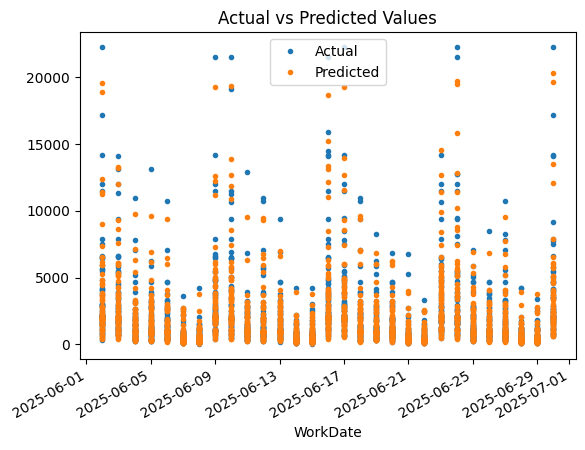

In [48]:
test[target].plot(style='.', label='Actual')
test.predictions.plot(style='.', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [49]:
r2 = r2_score(np.exp(y_test), preds)

print(f'R2 Score: {r2:.04f}')

R2 Score: 0.9645


A $R^2$ score of 0.96 indicates our feature preprocessing, hyperparameter tuning, and model selection have resulted in a high accuracy when predicting ``TotalRevenue``<br></br>

While this is a very good result, in the real world, it's rare to see this good of performance in any model. Data is not always as clear cut and clean as that found in this dataset.<br></br>

There are a few things you can do to improve a models accuracy:
- Tune more hyperparameters such as ``alpha``, ``lambda``, and ``gamma`` for regularization and help minimize error loss or ``max_depth`` and ``min_child_weight`` to help determine the complexity of the model
- Remove outlier data that the model may not be able to predict very well
- Create/remove additional features<br></br>

Often times, having domain knowledge is the most useful aspect for determining how to best improve the model's performance<br></br>

For example, if this were a real-world dataset, we could identify the customers and locations where the model performed the worst and do a deeper dive into the data.

In [50]:
test['pct_error'] = np.abs(test.TotalRevenue - test.predictions) / test.TotalRevenue

In [51]:
test[
    ['Location', 'Customer', 'TotalRevenue', 'predictions', 'pct_error']
].groupby(['Location'], as_index=False)[['TotalRevenue', 'predictions', 'pct_error']].sum().sort_values(by='pct_error', ascending=False).head()

,Location,TotalRevenue,predictions,pct_error
2,Chicago,558481.05,515897.093750,22.023742
12,Sacramento,217341.46,202695.234375,16.932838
8,Milwaukee,207102.26,191633.062500,16.376734
4,Detroit,191248.53,199077.968750,16.316583
6,Los Angeles,367542.38,337580.687500,15.921731


In [52]:
test[
    ['Location', 'Customer', 'TotalRevenue', 'predictions', 'pct_error']
].groupby(['Customer'], as_index=False)[['TotalRevenue', 'predictions', 'pct_error']].sum().sort_values(by='pct_error', ascending=False).head()

,Customer,TotalRevenue,predictions,pct_error
3,Costco,425272.10,3.934182e+05,36.122333
0,Amazon,578400.65,5.384794e+05,34.311422
4,Home Depot,1359102.93,1.278333e+06,27.898641
10,Target,296881.88,2.755302e+05,27.653975
8,Starbucks,254244.33,2.406003e+05,24.812307


<a id="8"></a>
### 8 - Predict the Future

Now that we know our satisfied with our model's performance on past data, we can begin to predict the future.<br></br>

In typical time-series forecasting models, you can create a single date range index, input features, and train a model on your known data to predict the future. With supply chain data, the process is slightly more complex for a couple of reasons:
- Customers are not delivered to every single day
- There are multiple customers and locations to account for every day
- We're relying on lag and rolling features, so recursive predictions are necessary to ensure these features are utilized to their fullest potential



To combat the first two obstacles, we will start by determining the probability of a customer being delivered to in each location on any given day of the week

In [53]:
groupby_cols = ['Location', 'Customer', 'BusinessType']

Determining a relatively recent service period is crucial for a few reasons:

- The dataset spans 5 years and the industry is always changing
- Customer demand may change over time
- Customers are lost/added

In [54]:
service_period = df[df.index >= df.index.max() - timedelta(days=90)]

In [55]:
service_days = (
    service_period.reset_index()
    .groupby(groupby_cols + ['dayofweek'])
    .agg(ServiceCount=('WorkDate', 'nunique'))
    .reset_index()
)

As mentioned, not every customer gets a delivery every single day. In order to determine the probability of a customer receiving a delivery on any given day of the week, we need to determine how many opportun

In [56]:
opportunities = (
    create_features(pd.DataFrame(index=service_period.index)).reset_index()
    .groupby('dayofweek', group_keys=False)
    .agg(OpportunityCount=('WorkDate', 'nunique'))
    .reset_index()
)

In [57]:
service_days.head()

,Location,Customer,BusinessType,dayofweek,ServiceCount
0,Atlanta,Amazon,Final Mile,0,12
1,Atlanta,Amazon,Final Mile,1,10
2,Atlanta,Amazon,Final Mile,2,11
3,Atlanta,Amazon,Final Mile,3,12
4,Atlanta,Amazon,Final Mile,4,13


In [58]:
opportunities

,dayofweek,OpportunityCount
0,0,13
1,1,13
2,2,13
3,3,13
4,4,13
5,5,13
6,6,13


In [59]:
service_days = service_days.merge(
    opportunities,
    on='dayofweek',
    how='right'
)

service_days['ServiceProbability'] = service_days.ServiceCount / service_days.OpportunityCount

In [60]:
service_prob = (
    service_days.sort_values(groupby_cols + ['ServiceProbability'], ascending=False)
    .groupby(groupby_cols).head(7)
    .fillna(0)
)

In [61]:
service_prob.sort_values(by=['Location', 'Customer', 'dayofweek']).head(7)

,Location,Customer,BusinessType,dayofweek,ServiceCount,OpportunityCount,ServiceProbability
0,Atlanta,Amazon,Final Mile,0,12,13,0.923077
119,Atlanta,Amazon,Final Mile,1,10,13,0.769231
238,Atlanta,Amazon,Final Mile,2,11,13,0.846154
356,Atlanta,Amazon,Final Mile,3,12,13,0.923077
475,Atlanta,Amazon,Final Mile,4,13,13,1.000000
594,Atlanta,Amazon,Final Mile,5,11,13,0.846154
713,Atlanta,Amazon,Final Mile,6,13,13,1.000000


Now we can decide how far in the future we want to predict and start building a dataset based on the probability a customer will be delivered to on any given day

In [62]:
future_dates = pd.date_range(df.index.max()+timedelta(days=1), periods=30)

In [63]:
future = pd.DataFrame(future_dates, columns=['WorkDate']).set_index('WorkDate')
future = create_features(future)

future.head()

,dayofweek,weekofmonth,weekofyear,quarter,month,year,month_start,month_end,year_start,year_end,isWeekend,isHoliday,isDayBeforeHoliday,isDayAfterHoliday
WorkDate,,,,,,,,,,,,,,
2025-07-01,1,1,27,3,7,2025,True,False,False,False,False,False,False,False
2025-07-02,2,1,27,3,7,2025,False,False,False,False,False,False,False,False
2025-07-03,3,1,27,3,7,2025,False,False,False,False,False,False,True,False
2025-07-04,4,1,27,3,7,2025,False,False,False,False,False,True,False,False
2025-07-05,5,1,27,3,7,2025,False,False,False,False,True,False,False,True


In [64]:
def estimateServiceDays(dates_df, prob_df):
    # Uses the determined service probability to "predict" which days a customer will receive a delivery
    dfs = []
    for _, row in prob_df.iterrows():
        service_days = dates_df[dates_df.dayofweek == row['dayofweek']].sample(frac=row['ServiceProbability'])
        for col in groupby_cols:
            service_days[col] = row[col]
        dfs.append(service_days)

    return pd.concat(dfs)

In [65]:
future = estimateServiceDays(future, service_prob).sort_index()

future.head()

,dayofweek,weekofmonth,weekofyear,quarter,month,year,month_start,month_end,year_start,year_end,isWeekend,isHoliday,isDayBeforeHoliday,isDayAfterHoliday,Location,Customer,BusinessType
WorkDate,,,,,,,,,,,,,,,,,
2025-07-01,1,1,27,3,7,2025,True,False,False,False,False,False,False,False,Dallas,Target,Middle Mile
2025-07-01,1,1,27,3,7,2025,True,False,False,False,False,False,False,False,Milwaukee,Costco,First Mile
2025-07-01,1,1,27,3,7,2025,True,False,False,False,False,False,False,False,San Diego,Starbucks,Middle Mile
2025-07-01,1,1,27,3,7,2025,True,False,False,False,False,False,False,False,Dallas,Costco,First Mile
2025-07-01,1,1,27,3,7,2025,True,False,False,False,False,False,False,False,Sacramento,Target,Middle Mile


In [66]:
# Combine the past and future data together

future['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future]).sort_index()

In [67]:
drop_cols.extend(['isFuture'])

In [68]:
# We want to predict TotalRevenue, OrderCount, and NumberOfPieces so we will create dictionaries for the models, preprocessors, and features used
# to predict each target variable

models = {}
preprocessors = {}
features = {}

for target in ['TotalRevenue', 'OrderCount', 'NumberOfPieces']:
    print(f'Fitting model for {target} prediction')
    x_train = df.copy().drop(drop_cols, axis=1)
    y_train = np.log(df[target])

    preprocessor = preprocess(x_train)
    x_train_preprocessed = preprocessor.transform(x_train)

    model = XGBRegressor(n_jobs=-1, random_state=42, tree_method='hist', **model_params)

    model.fit(
        x_train_preprocessed,
        y_train,
        eval_set=[(x_train_preprocessed, y_train)],
        verbose=10
    )

    models[target] = model
    preprocessors[target] = preprocessor
    features[target] = x_train.columns.tolist()
    print()

Fitting model for TotalRevenue prediction
[0]	validation_0-rmse:6.17955
[10]	validation_0-rmse:2.16603
[20]	validation_0-rmse:0.77796
[30]	validation_0-rmse:0.32151
[40]	validation_0-rmse:0.19890
[49]	validation_0-rmse:0.17345

Fitting model for OrderCount prediction
[0]	validation_0-rmse:2.35509
[10]	validation_0-rmse:0.83315
[20]	validation_0-rmse:0.30871
[30]	validation_0-rmse:0.13688
[40]	validation_0-rmse:0.08732
[49]	validation_0-rmse:0.07168

Fitting model for NumberOfPieces prediction
[0]	validation_0-rmse:3.74464
[10]	validation_0-rmse:1.32046
[20]	validation_0-rmse:0.49083
[30]	validation_0-rmse:0.23330
[40]	validation_0-rmse:0.17242
[49]	validation_0-rmse:0.15972



As mentioned, we need to recursively predict each day because as we predict further into the future, the lag and rolling features will have less impact and negatively affect the results. Therefore, each day needs to sequentially predict the target variables and update the features.

In [69]:
def recursive_predictions(df):
    predictions = {col: [] for col in models.keys()}
    days = df.query('isFuture').index.unique()

    for day in tqdm(days):
        df = addLags(df, [7, 14, 21, 30, 60, 90])
        df = df.groupby(['Location', 'Customer'], group_keys=False).apply(expand_group)

        for column, model in models.items():
            rows = df[df.index == day][features[column]]

            rows_preprocessed = preprocessors[column].transform(rows)

            predicted_values = np.exp(model.predict(rows_preprocessed))

            df.loc[df.index == day, column] = predicted_values
            predictions[column].append(predicted_values)

    return df, predictions

In [70]:
df_and_future_recursive, predictions = recursive_predictions(df_and_future)

100%|██████████| 30/30 [05:13<00:00, 10.45s/it]


In [71]:
for col, preds in predictions.items():
    df_and_future_recursive.loc[df_and_future_recursive.isFuture == True, f'{col}_prediction'] = np.concatenate(preds)

In [72]:
future_w_features_recursive = df_and_future_recursive.query('isFuture')

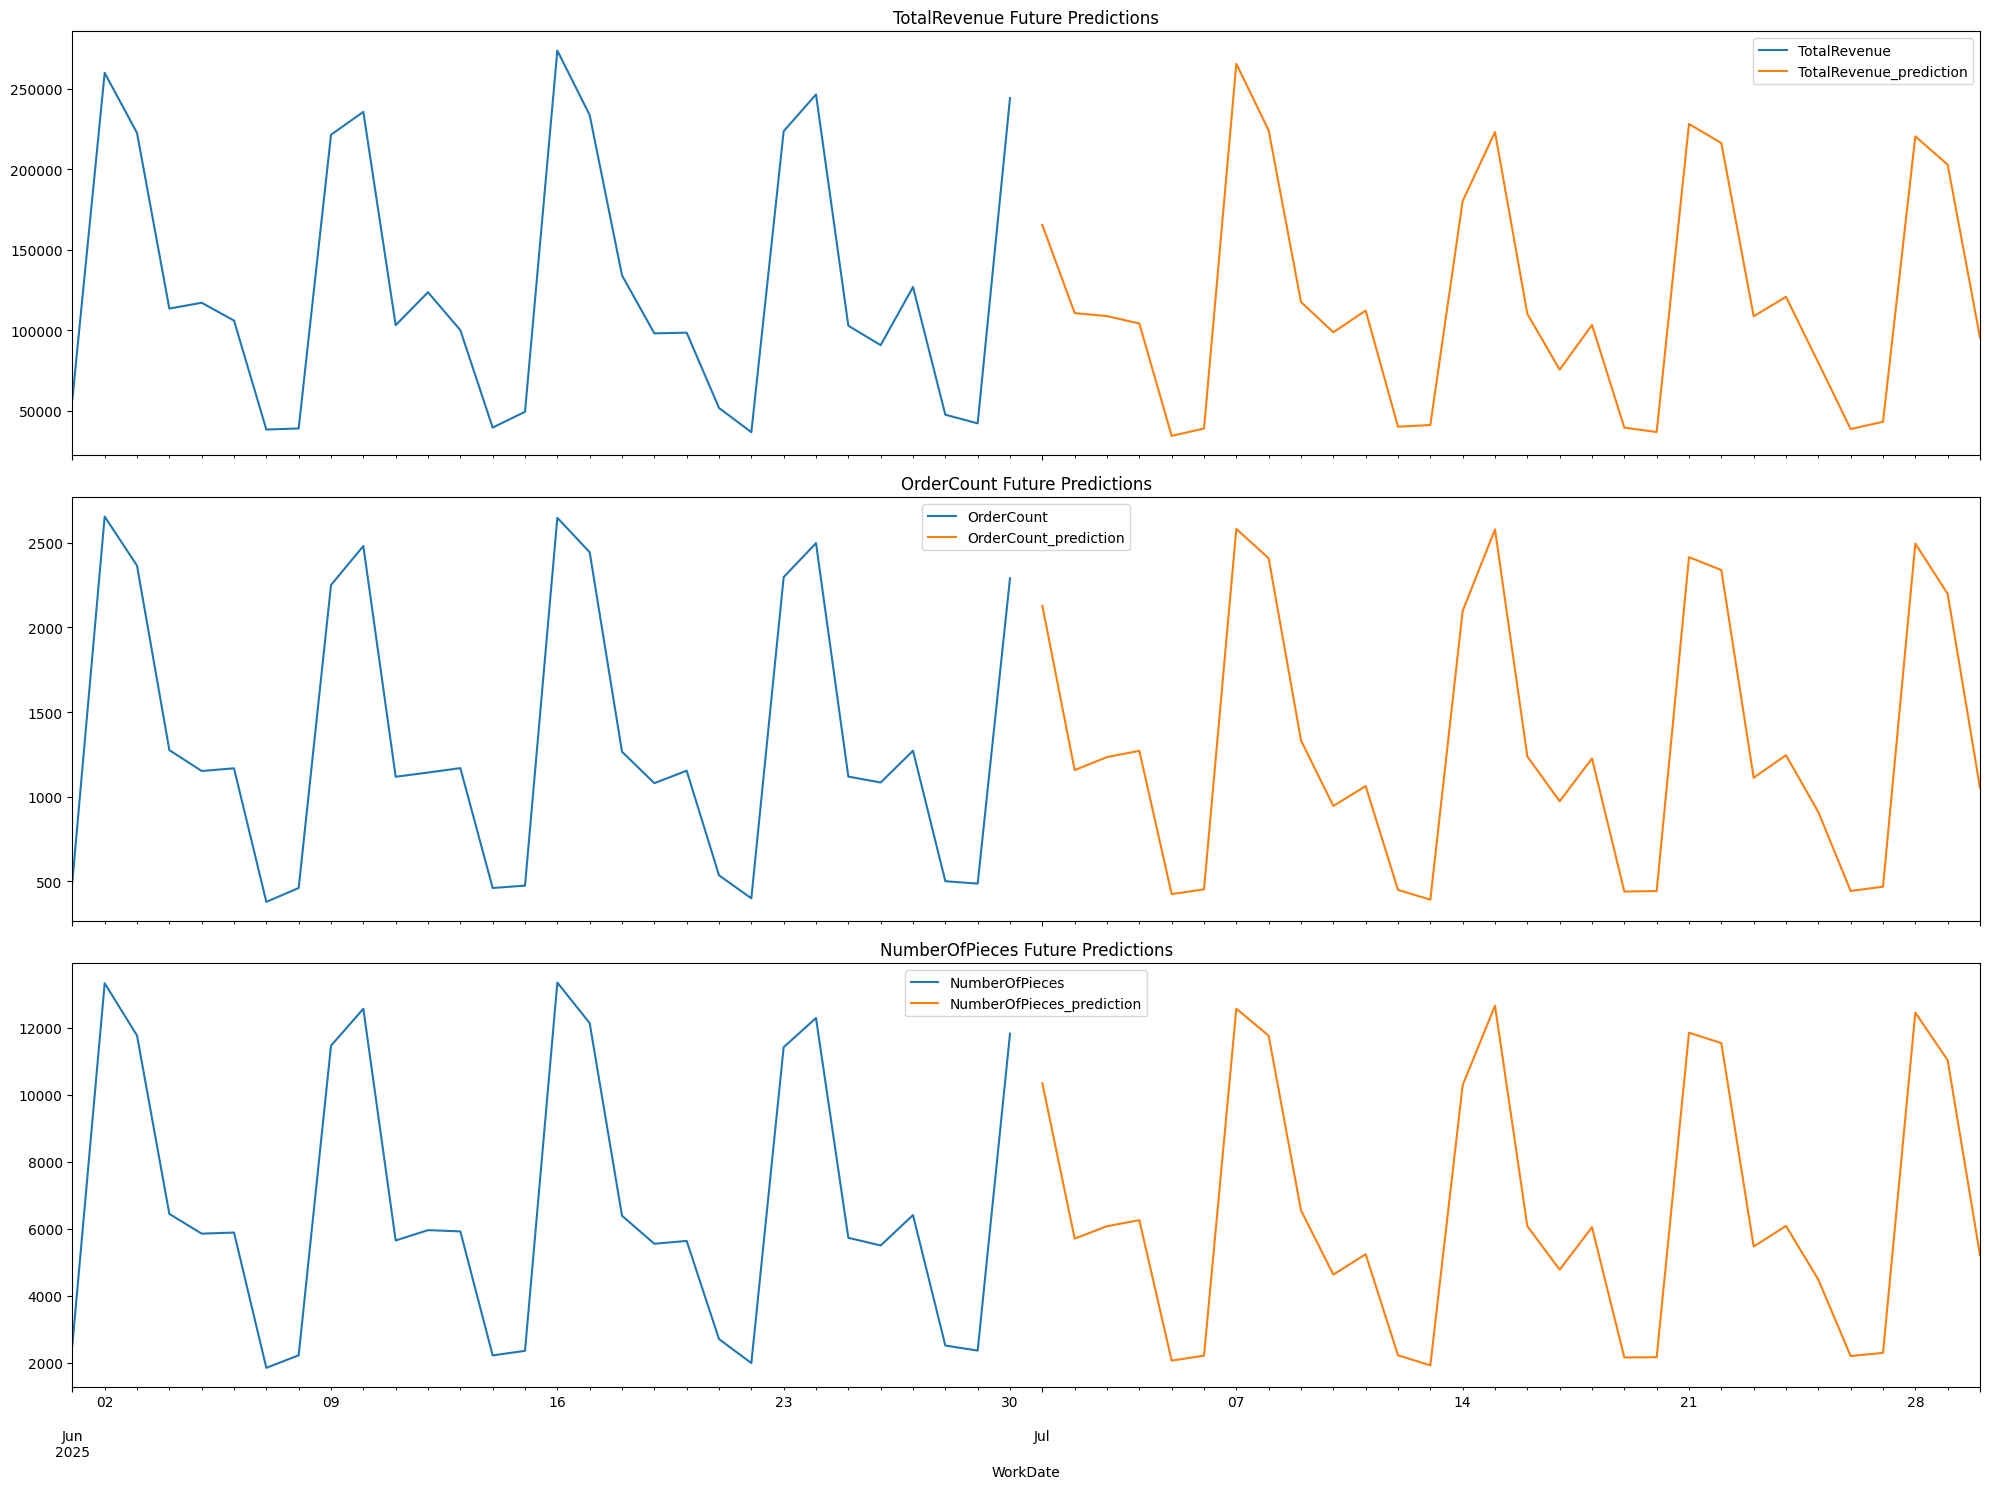

In [73]:
fig, ax = plt.subplots(3, 1, figsize=(20,15), sharex=True)
for idx, column in enumerate(['TotalRevenue', 'OrderCount', 'NumberOfPieces']):
    df[df.index >= future_w_features_recursive.index.min() - timedelta(days=30)].groupby('WorkDate', group_keys=False)[column].sum().plot(ax=ax[idx])
    future_w_features_recursive.groupby('WorkDate', group_keys=False)[f'{column}_prediction'].sum().plot(ax=ax[idx])
    ax[idx].set_title(f'{column} Future Predictions')
    ax[idx].legend()
plt.tight_layout()
plt.show()

<a id="9"></a>
### 9 - Conclusion

In this notebook, we have covered advanced techniques for cleaning, analyzing, and preprocessing time-series data to train a machine learning model that can accurately forecast customer demand and total revenue. Methods highlighted in this notebook can be used for various purposes such as demand planning, projections, and as performance benchmarks for the future. Feel free to comment or reach out about any oversights or general feedback on the material covered. Thank you!